In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import sys

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim

from scripts.BTK_generator import BTK_blend_generator as btk_generator
from scripts.FFT_calcs import FFT_IFFT_calc 

In [2]:
import sympy as smp
from sympy.integrals.transforms import fourier_transform
from sympy import expand, factor
from pprint import pprint

**Goal of this notebook** is to familiarize myself with Fourier Transforms, specifically FT of Gaussians. We do this analytically with checks by using `Sympy`. 

General equation for a non-rotated 2D Gaussian: $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2} - \frac{(y-y_0)^2}{2\sigma_y^2} \Big)$$

General equation for 2D Gaussian (includes rotation): $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$

I'll be using the equation that includes rotations in the code because we can create a non-rotated 2D gaussian by setting $\rho = 0$.

In [3]:
def gauss_2d(x0=0,
                y0=0,
                sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                A=1,
                N=128):
    '''
    General function to calculate 2D gaussian. Allows for circular, elliptical,
    rotated, and off-centered gaussians. The values of the Gaussian function are
    calculated by the given positions in the x and y meshgrid.
    
    Args:
    -----
        x0: int 
            The x-coordinate of the center of the Gaussian.
            Defaults to 0.
        y0: int
            The y-coordinate of the center of the Gaussian.
        rho: float
            The correlation coefficient. Measure of direction and magnitude of stretch/
            rotation. Values must be between [-1,1].
            Defaults to 0.5.
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
            
            
    Returns:
    --------
        gauss: np.ndarray
            The array containing the gaussian function evaluated at each point
            in the meshgrid. I.e. returns the image of the Gaussian.
    '''
    x = np.linspace(-10,10,N)
    y = np.linspace(-10,10,N)
    Xg, Yg = np.meshgrid(x, y)

    norm = 1 / (2*np.pi * sigma_x * sigma_y * np.sqrt(1-rho**2))
    exp_x = -(Xg-x0)**2 /(2*sigma_x**2 * (1-rho**2))
    exp_y = -(Yg-y0)**2 / (2*sigma_y**2 * (1-rho**2))
    exp_xy = (Xg-x0)*(Yg-y0)*rho / (sigma_x*sigma_y * (1-rho**2))
    
    rot_gauss = norm * np.exp(exp_x + exp_y + exp_xy)

    return rot_gauss

# 1. Non-rotated Gaussian FT

Start with this equation:  $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$

set $\rho=0$ to get it in the non-rotated form and then set $x_0=0, y_0=0$ for simplifcation and we get: $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2}\Big)$$

Next, we do the FT and we should get: $$\hat{f}(u,v) = \text{exp}\Big(-2\pi^2 (u^2 \sigma_x^2 + v^2 \sigma_y^2)\Big)$$

---

We check the analytical equation using `sympy`.

Start with the non-rotated 2D gaussian from above: 

$$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2}\Big)$$

To calculate the FT using `sympy` we'll break up this function into individual integrals because $f(x,y)$ is separable. **We do this because `sympy` can't handle the full 2D integral from the get-go.**

The separate 1D gaussians within the 2D gaussian is:

$$
\begin{align*}
f(x) &= \frac{1}{\sqrt{2\pi}\sigma_x} \text{exp}\Big(-\frac{x^2}{2\sigma_x^2}\Big) \\
f(y) &= \frac{1}{\sqrt{2\pi}\sigma_y} \text{exp}\Big(-\frac{y^2}{2\sigma_y^2}\Big)
\end{align*}
$$

And we find that the 2D FT does indeed match ie. it's:
$$
\hat{f}(u,v) = \text{exp}\Big(-2\pi^2 (u^2 \sigma_x^2 + v^2 \sigma_y^2)\Big)
$$

In [4]:
#Instantiate the spatial and frequency coordidnates 
# sympy symbols to be traced
x, u = smp.symbols('x, u', real=True)
y, v = smp.symbols('y, v', real=True)

# Instantiate any remaining symbols that will be in the 
# sympy functions equation
sigma_x = smp.symbols('\sigma_x', real=True)
sigma_y = smp.symbols('\sigma_y', real=True)

# Create/instantiate the separate 1D gaussian equations to compute
# the individual FTs

# x FT #
fx = 1/(smp.sqrt(2 * smp.pi) * sigma_x) * smp.exp(-  x**2 / (2 * sigma_x**2)) #Fx func
integrand_x = fx * smp.exp(-2 * smp.pi * smp.I * u * x) # Fx FT integrand
x_FT = smp.integrate(integrand_x, (x, -smp.oo, smp.oo)) # Fx FT integral
xsimple_FT = smp.simplify(x_FT) # simplify data
xsimple_FT = xsimple_FT.args[0][0] # xsimple_FT is a piecewise eqn. of (expr, cond) taking
                                   # func.args[0] takes the first choice in piecewise
                                   # func.args[0][0] takes the expr of the first choice 

# y FT #
fy = 1/(smp.sqrt(2 * smp.pi) * sigma_y) * smp.exp(-  y**2 / (2 * sigma_y**2))
integrand_y = fy * smp.exp(-2 * smp.pi * smp.I * v * y)
y_FT = smp.integrate(integrand_y, (y, -smp.oo, smp.oo))
ysimple_FT = smp.simplify(y_FT)
ysimple_FT = ysimple_FT.args[0][0]

# 2D FT
FT_2D = smp.simplify(xsimple_FT * ysimple_FT)
FT_2D

exp(2*pi**2*(-\sigma_x**2*u**2 - \sigma_y**2*v**2))

In [5]:
def analytical_nonrot_gauss(sigma_x=1.0,
                            sigma_y=1.0,
                            A=1,
                            N=128,
                            d=0.1):
    """
    Function that calculates the FT of a non-rotated 2D Gaussian using the
    analytical solution I calculated.
    
    Args:
    -----
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
        d: float
            Sample spacing (inverse of the sampling rate).
            Defaults to 0.1
            
    Returns:
    --------
        gauss: np.ndarray
            Array of the original inputted 2D Gaussian
        FT: np.ndarray
            Complex array of the FT of the 2D Gaussian that was 
            computed via the analytical equation above.
    """
    # Get the gaussian and FT of the gaussian
    gauss = gauss_2d(sigma_x=sigma_x, sigma_y=sigma_y, rho=0, A=A, N=N)

     # Get the frequency coords of the FT ie. x/y -> u/v
    FreqCompRows = np.fft.fftfreq(gauss.shape[0],d=d) #u
    u = FreqCompRows
    FreqCompCols = np.fft.fftfreq(gauss.shape[1],d=d) #b
    v = FreqCompCols
    
    # Create frequency grid
    Ug, Vg = np.meshgrid(u, v)
    
    # Calc prefactor of the analytical FT
    prefactor= 1 # old eqn had 1 here
    expo = np.exp(-2*np.pi**2 * (Ug**2*sigma_x**2 + Vg**2*sigma_y**2))
    FT = prefactor*expo
    FT = fft.fftshift(FT)
    return gauss, FT

def visualize_nonrot_FT(sigma_x=1.0,
                        sigma_y=1.0,
                        A=1,
                        N=128,
                        d=0.1):
    """
    Function that visualizes a comparison between the analytical FT
    and the FFT output.
    
    Args:
    -----
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
        d: float
            Sample spacing (inverse of the sampling rate).
            Defaults to 0.1
            
    Returns:
    --------
        Plots of the analytical FT versus the FFT output
    """
    
    
    ingauss, analyFT = analytical_nonrot_gauss(sigma_x=sigma_x,
                                               sigma_y=sigma_y,
                                               N=N,
                                               d=d, 
                                               A=A)
    FFT = fft.fftshift(fft.fft2(ingauss))
    
#     vmax, vmin = np.percentile(np.abs(FFT), (99,1))
#     vmax, vmin = np.percentile(ingauss, (99,1))

    fig, axes = plt.subplots(2, 2, figsize=(30,26))
    axes[0,0].imshow(ingauss)
    axes[0,0].axis('off')
    axes[0,0].set_title('Input', fontsize=30)
    axes[0,1].imshow(np.abs(analyFT))
    axes[0,1].axis('off')
    axes[0,1].set_title('Analytical FT', fontsize=30)
    axes[1,0].imshow(ingauss)
    axes[1,0].axis('off')
    axes[1,0].set_title('Input', fontsize=30)
    axes[1,1].imshow(np.abs(FFT))
    axes[1,1].axis('off')
    axes[1,1].set_title('FFT FT', fontsize=30)


    plt.tight_layout()
    plt.show()

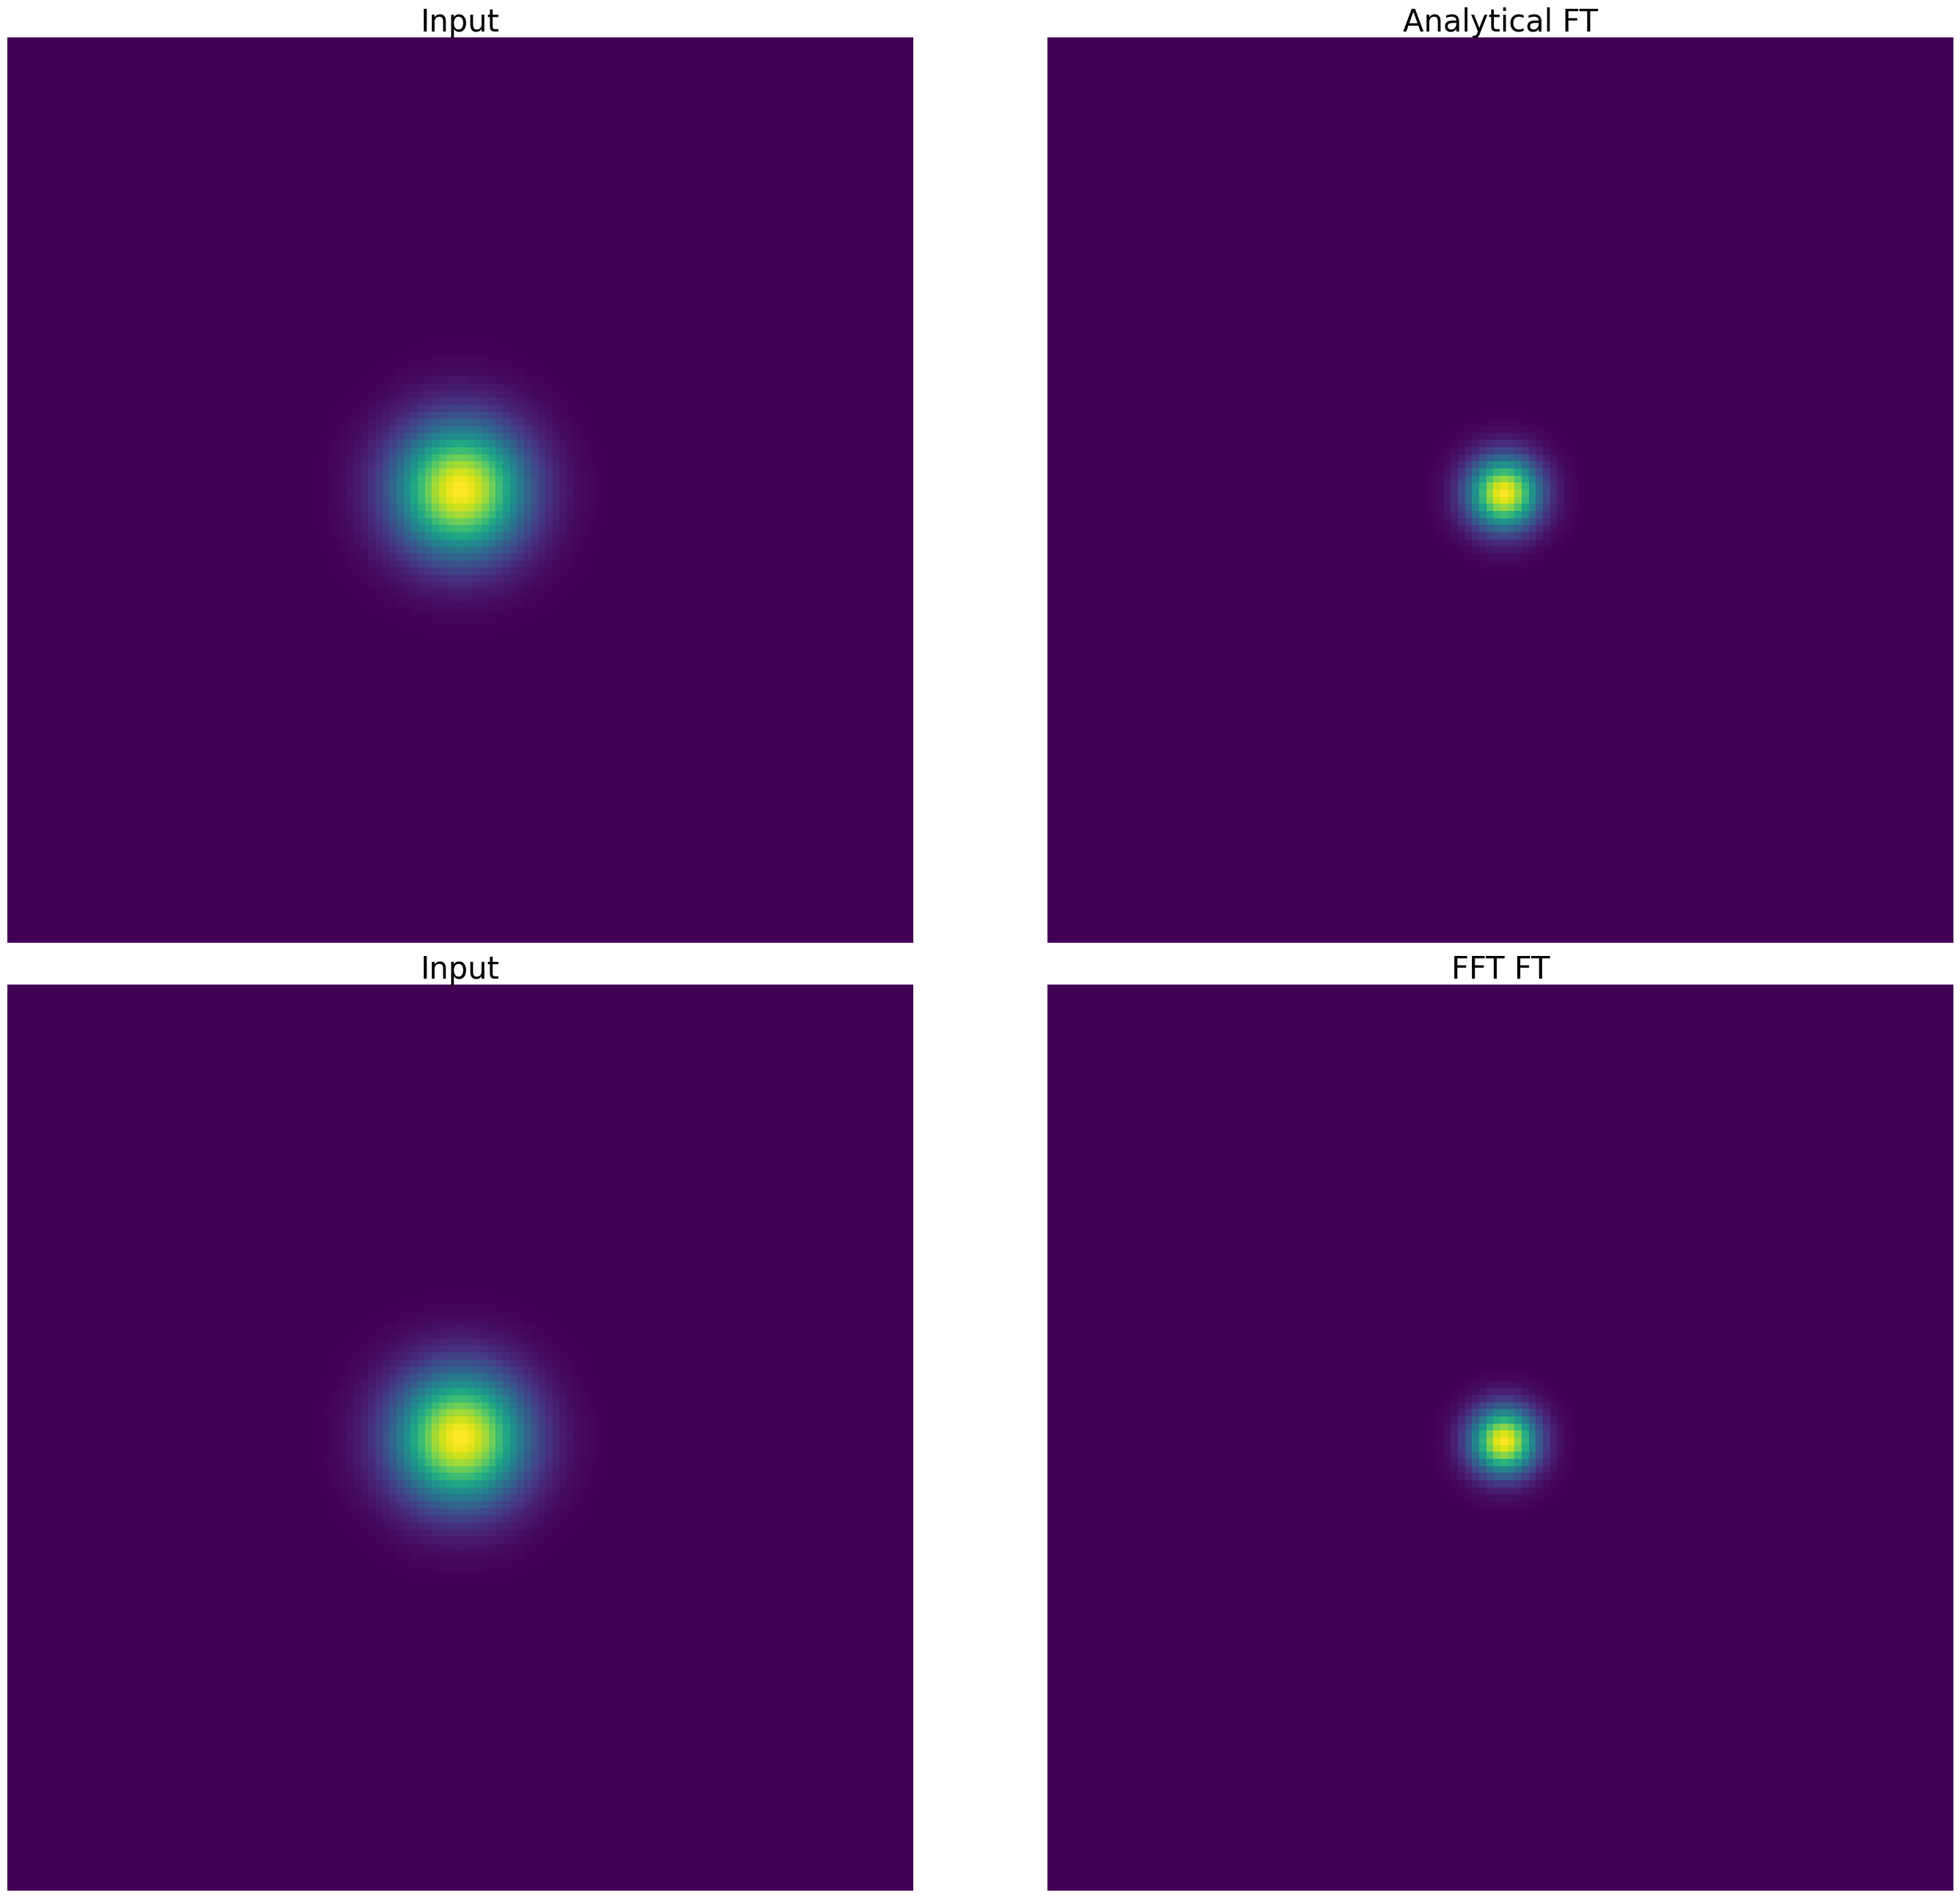

In [6]:
visualize_nonrot_FT(d=0.17)

In [7]:
# ingauss, analyFT = analytical_nonrot_gauss(sigma_x=1.,
#                                            sigma_y=1.,
#                                            N=128,
#                                            d=0.17, 
#                                            A=1)
# FFT = fft.fftshift(fft.fft2(ingauss))

# plt.imshow(np.isclose(np.abs(analyFT), np.abs(FFT)))

### 1.1.1 Using for loops for the FT

In [8]:
# # Using for loops to see if this illuminates anything
# sig_x = 1.3
# sig_y = 1.3
# N = 128

# gauss = gauss_2d(x0=0,
#                 y0=0,
#                 sigma_x=sig_x,
#                 sigma_y=sig_y,
#                 rho=0,
#                 N=N)

# FFT = fft.fftshift(fft.fft2(gauss))


# FT_arr = np.zeros((N, N), np.complex128)
# for k in range(N):
#     for j in range(N):
#         w_x = np.exp(-1j*2*np.pi*(k/N))
#         w_y = np.exp(-1j*2*np.pi*(j/N))
        
#         FT_arr[k, j] += gauss[k,j] * w_x * w_y
        
        
        
# fig, axes = plt.subplots(2, 2, figsize=(30,26))
# axes[0,0].imshow(gauss)
# axes[0,0].axis('off')
# axes[0,0].set_title('Input', fontsize=30)
# axes[0,1].imshow(np.abs(FT_arr))
# axes[0,1].axis('off')
# axes[0,1].set_title('Analytical FT', fontsize=30)
# axes[1,0].imshow(gauss)
# axes[1,0].axis('off')
# axes[1,0].set_title('Input', fontsize=30)
# axes[1,1].imshow(np.abs(FFT))
# axes[1,1].axis('off')
# axes[1,1].set_title('FFT FT', fontsize=30)


# plt.tight_layout()
# plt.show()

# 2. Rotated Gaussian FT

Start with: $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$

Set $x_0=0$ and $y_0=0$ for simplicity:
$$
f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2(1-\rho^2)} - \frac{y^2}{2\sigma_y^2(1-\rho^2)} + \frac{xy\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)
$$

Calculate the FT: $$\hat{f}(u,v) = \text{exp}\Big(-2\pi^2 \big[\sigma_x^2u^2 + \sigma_y^2v^2 + 2\sigma_x\sigma_y\rho uv \big] \Big)$$

---

Checks out

In [9]:
def analytical_rotgauss_FT(sigma_x=1.0,
                            sigma_y=1.0,
                            rho=0.5,
                            A=1,
                            N=128,
                            d=0.1):

    """
    Function to calculate the FT of a rotated 2D gaussian via
    the analytical equation.
    
    Args:
    -----
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
        d: float
            Sample spacing (inverse of the sampling rate).
            Defaults to 0.1
            
    Returns:
    --------
        gauss: np.ndarray
            2D array containing the original inputted 2D Gaussian
        rot_FT: np.ndarray
            2D array containing the FT of the analytical equation
            above of the inputted 2D Gaussian.
    """
    
    # Get the gaussian 
    gauss = gauss_2d(sigma_x=sigma_x, sigma_y=sigma_y, rho=rho, N=N)

    # Get the frequency coords of the FT ie. x/y -> u/v
    FreqCompRows = np.fft.fftfreq(gauss.shape[0],d=d) #u
    u = FreqCompRows
    FreqCompCols = np.fft.fftfreq(gauss.shape[1],d=d) #v
    v = FreqCompCols
    
    # Create frequency grid
    Ug, Vg = np.meshgrid(u, v)
    
    exp_u = -2*np.pi**2 * sigma_x**2 * Ug**2
    exp_v = -2*np.pi**2 * sigma_y**2 * Vg**2
    exp_uv = -4*np.pi**2 * sigma_x * sigma_y * rho * Ug * Vg
    
    rot_FT = np.exp(exp_u + exp_v + exp_uv)
    rot_FT = fft.fftshift(rot_FT)
    
    return gauss, rot_FT

def visualize_rot_FT(sigma_x=1.0,
                     sigma_y=1.0,
                     rho=0.5,
                     A=1,
                     N=128,
                     d=0.1):
    """
    Function that visualizes a comparison between the analytical FT
    and the FFT output.
    
    Args:
    -----
        sigma_x: float
            The width of the gaussian in the x-direction.
            Defaults to 1.0
        sigma_y: float
            The width of the gaussian in the y-direction.
            Defaults to 1.0
        A: int
            The amplitude or "height" of the Gaussian.
        N: int
            Number of samples to create.
            E.g. if N=128 we'll create a meshgrid that is (128,128) and thus return
            an (128,128) Gaussian image.
            Defaults to 128.
        d: float
            Sample spacing (inverse of the sampling rate).
            Defaults to 0.1
            
    Returns:
    --------
        Plots of the analytical FT versus the FFT output
    """
    
    
    ingauss, analyFT = analytical_rotgauss_FT(sigma_x=sigma_x,
                                               sigma_y=sigma_y,
                                               rho=rho,
                                               N=N,
                                               d=d, 
                                               A=A)
    FFT = fft.fftshift(fft.fft2(ingauss))

    fig, axes = plt.subplots(2, 2, figsize=(30,26))
    axes[0,0].imshow(ingauss)
    axes[0,0].axis('off')
    axes[0,0].set_title('Input', fontsize=30)
    axes[0,1].imshow(np.abs(analyFT))
    axes[0,1].axis('off')
    axes[0,1].set_title('Analytical FT', fontsize=30)
    axes[1,0].imshow(ingauss)
    axes[1,0].axis('off')
    axes[1,0].set_title('Input', fontsize=30)
    axes[1,1].imshow(np.abs(FFT))
    axes[1,1].axis('off')
    axes[1,1].set_title('FFT FT', fontsize=30)


    plt.tight_layout()
    plt.show()

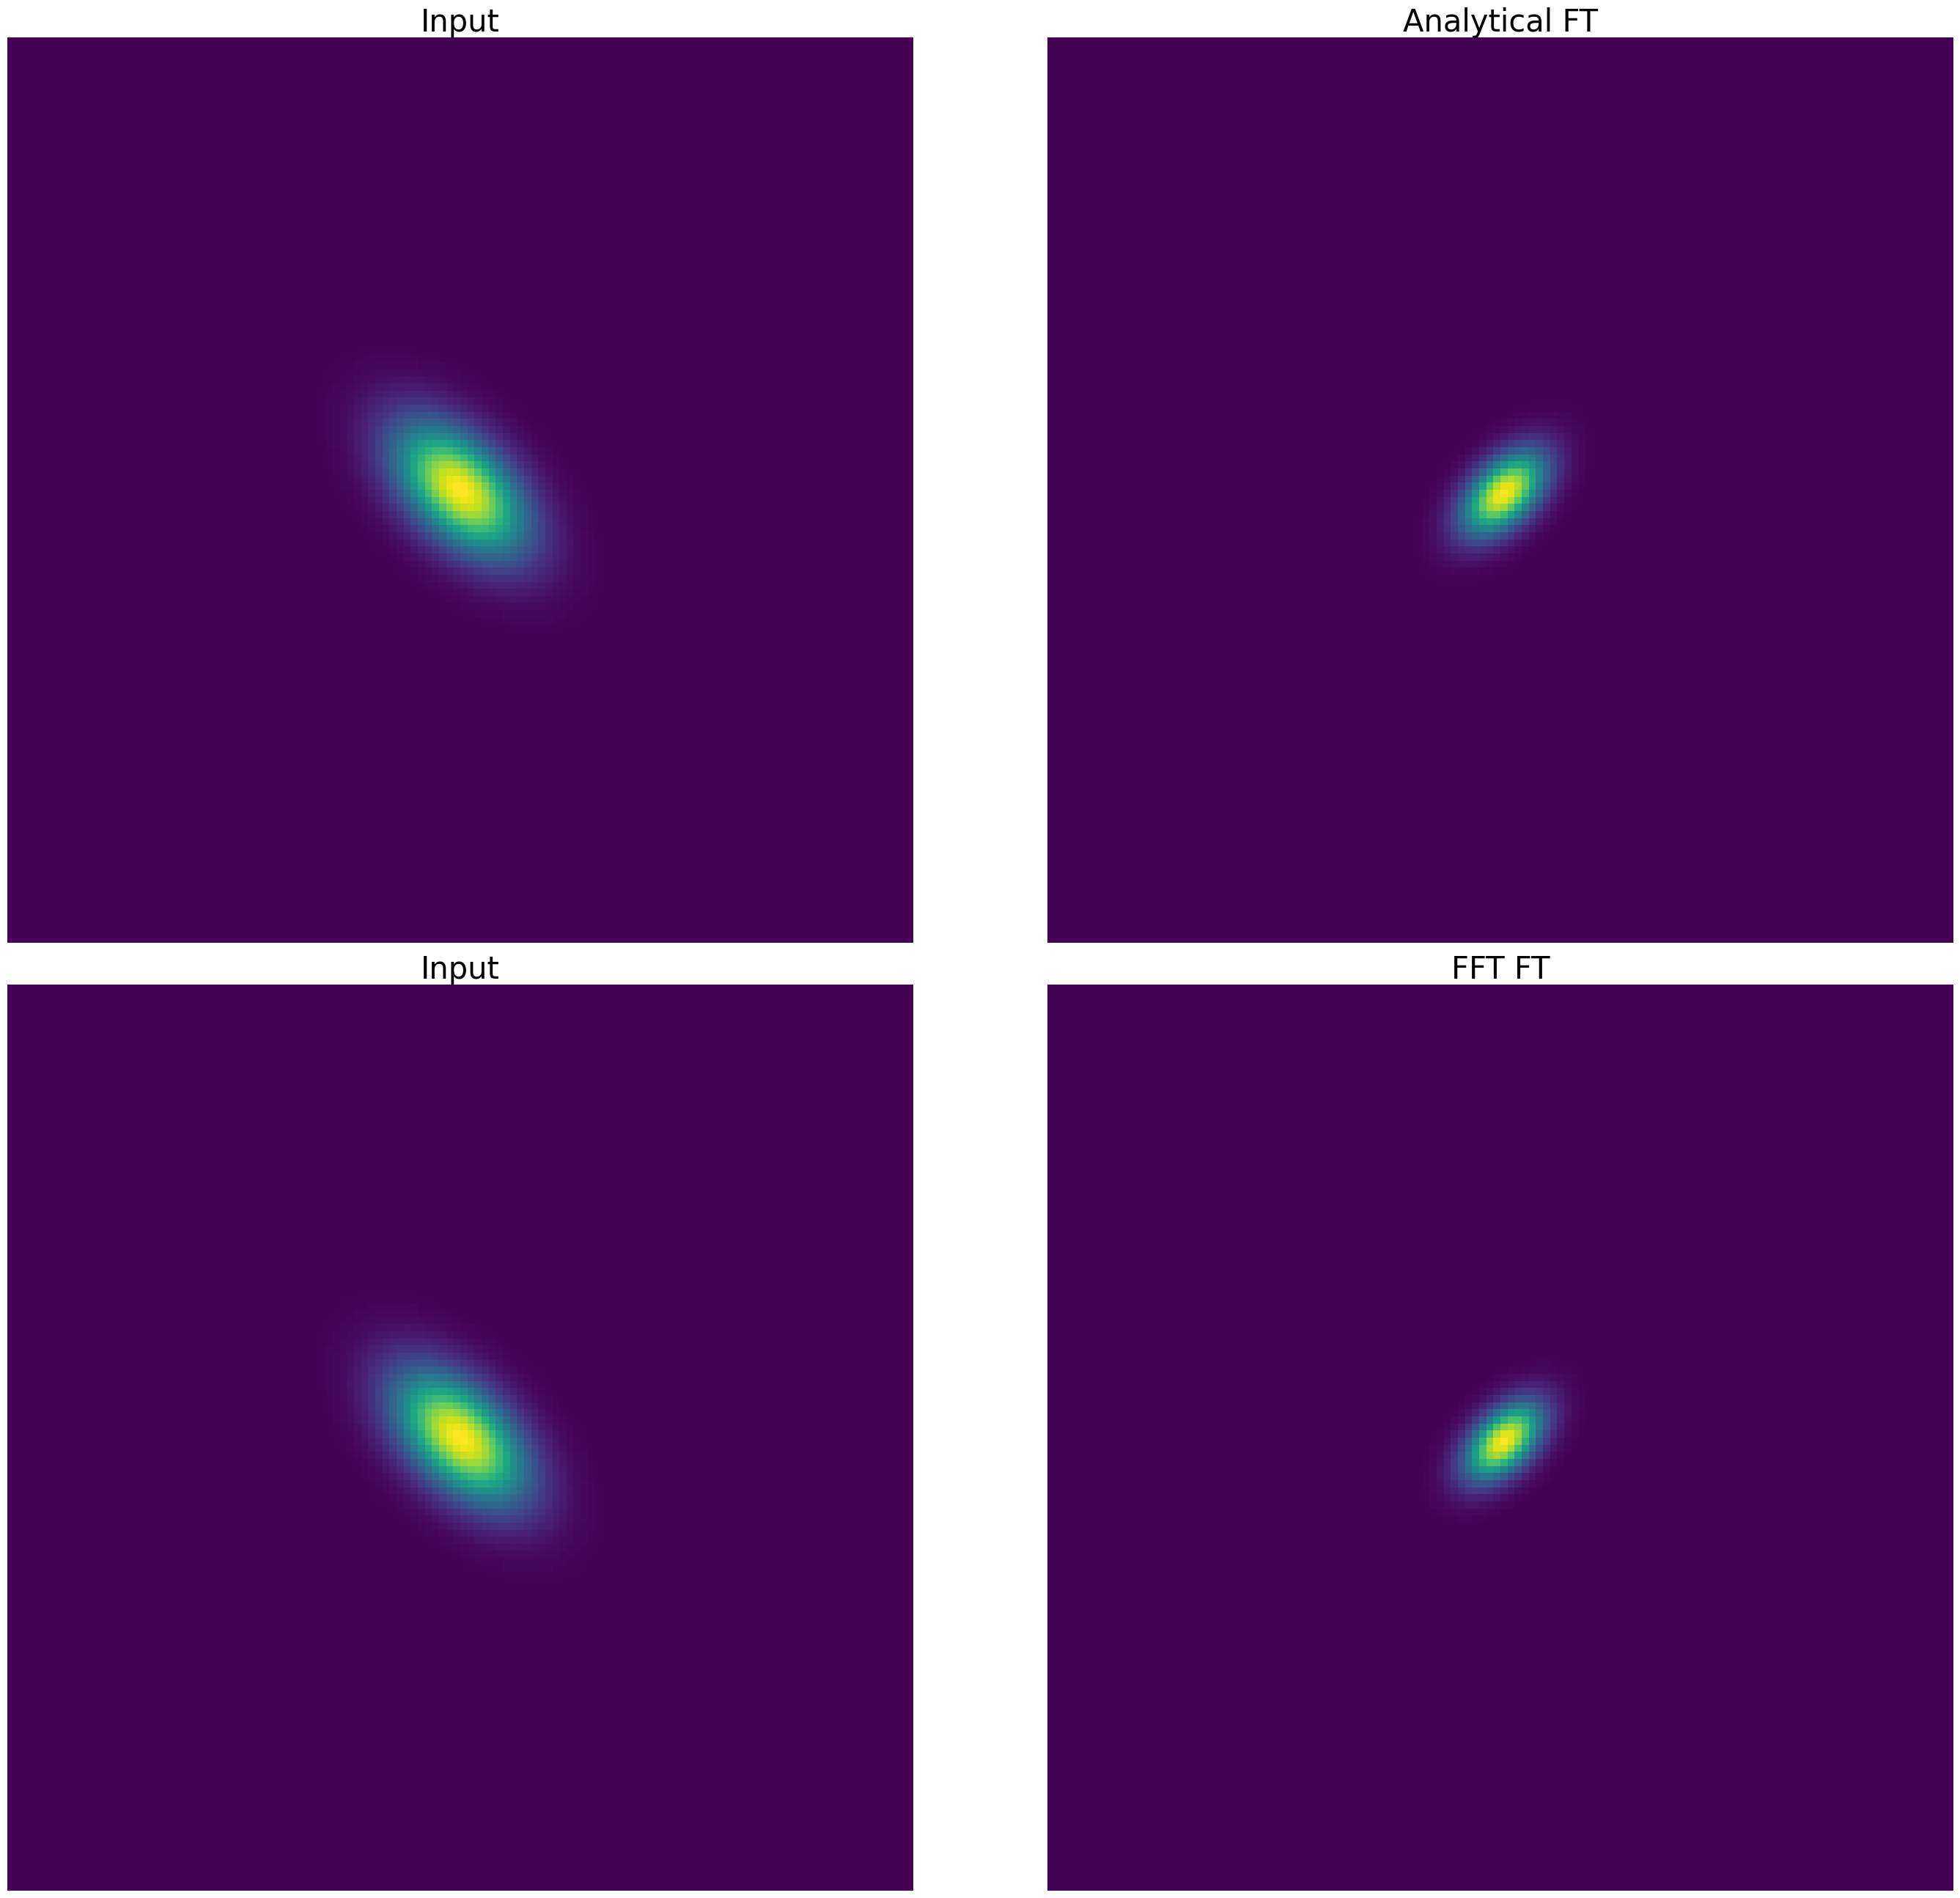

In [10]:
visualize_rot_FT(d=0.17)

### 2.1.1 `Sympy` check (doesn't work well)

Using `sympy.fourier_transform` because the doing separable equations doesn't go through. Again, we use:

$$
f(x,y) = \frac{1}{A} \text{exp}\Big(-\frac{x^2}{b_1} - \frac{y^2}{b_2} + \frac{xy}{b_3} \Big)
$$


where,

$$
\begin{align*}
A &= 2\pi \sigma_x \sigma_y \sqrt{1-\rho^2} \\
b_1 &= 2\sigma_x^2(1-\rho^2) \\
b_2 &= 2\sigma_y^2(1-\rho^2) \\
b_3 &= \sigma_x\sigma_y(1-\rho^2) \\
\end{align*}
$$

In [11]:
#Instantiate the spatial and frequency coordidnates 
# sympy symbols to be traced
x, u = smp.symbols('x, u', real=True)
y, v = smp.symbols('y, v', real=True)

# Instantiate any remaining symbols that will be in the 
# sympy functions equation
A = smp.symbols('A', real=True, positive=True)
b1 = smp.symbols('b_1', real=True, positive=True)
b2 = smp.symbols('b_2', real=True, positive=True)
b3 = smp.symbols('b_3', real=True, positive=True)

# fxy #
fxy =  (1/A)* smp.exp(-(x**2/b1) - (y**2/b2) + (x*y/b3)) #Fxy func
fxy

exp(x*y/b_3 - y**2/b_2 - x**2/b_1)/A

In [12]:
# FT of fxy #
f_FT_x = fourier_transform(fxy, x, u).simplify() # FT in x-coords
f_FT = fourier_transform(f_FT_x, y, v).simplify() # FT in y-coords
f_FT

sqrt(pi)*sqrt(b_1)*FourierTransform(exp(b_1*(2*I*pi*b_3*u - y)**2/(4*b_3**2) - y**2/b_2), y, v)/A

In [13]:
Fx_y = smp.exp( ((2* smp.I * smp.pi * b3 * u - y)**2/(4*b3**2)) - (y**2/b2)) 
Fxy = fourier_transform(Fx_y, y, v).simplify()
Fxy

FourierTransform(exp((2*I*pi*b_3*u - y)**2/(4*b_3**2) - y**2/b_2), y, v)

In [14]:
# y FT #
Fx_y = smp.exp( ((2* smp.I * smp.pi * b3 * u - y)**2/(4*b3**2)) - (y**2/b2)) 
integrand_y = Fx_y * smp.exp(-2 * smp.pi * smp.I * v * y)
Fxy_FT = smp.integrate(integrand_y, (y, -smp.oo, smp.oo))
ysimple_FT = smp.simplify(Fxy_FT)
ysimple_FT = ysimple_FT.args[0][0]
ysimple_FT

2*sqrt(pi)*sqrt(b_2)*b_3*sqrt(-1/(b_2 - 4*b_3**2))*exp(pi**2*(4*b_2*b_3**2*v**2/(b_2 - 4*b_3**2) + 4*b_2*b_3*u*v/(b_2 - 4*b_3**2) + b_2*u**2/(b_2 - 4*b_3**2) - u**2))

where,

$$
\begin{align*}
A &= 2\pi \sigma_x \sigma_y \sqrt{1-\rho^2} \\
b_1 &= 2\sigma_x^2(1-\rho^2) \\
b_2 &= 2\sigma_y^2(1-\rho^2) \\
b_3 &= \sigma_x\sigma_y(1-\rho^2) \\
\end{align*}
$$

We get $$\hat{f}(u,v) = \text{exp}\Big(-2\pi^2 \big[\sigma_x^2u^2 + \sigma_y^2v^2 + 2\sigma_x\sigma_y\rho uv \big] \Big)$$

# 3. Quick Reference Results

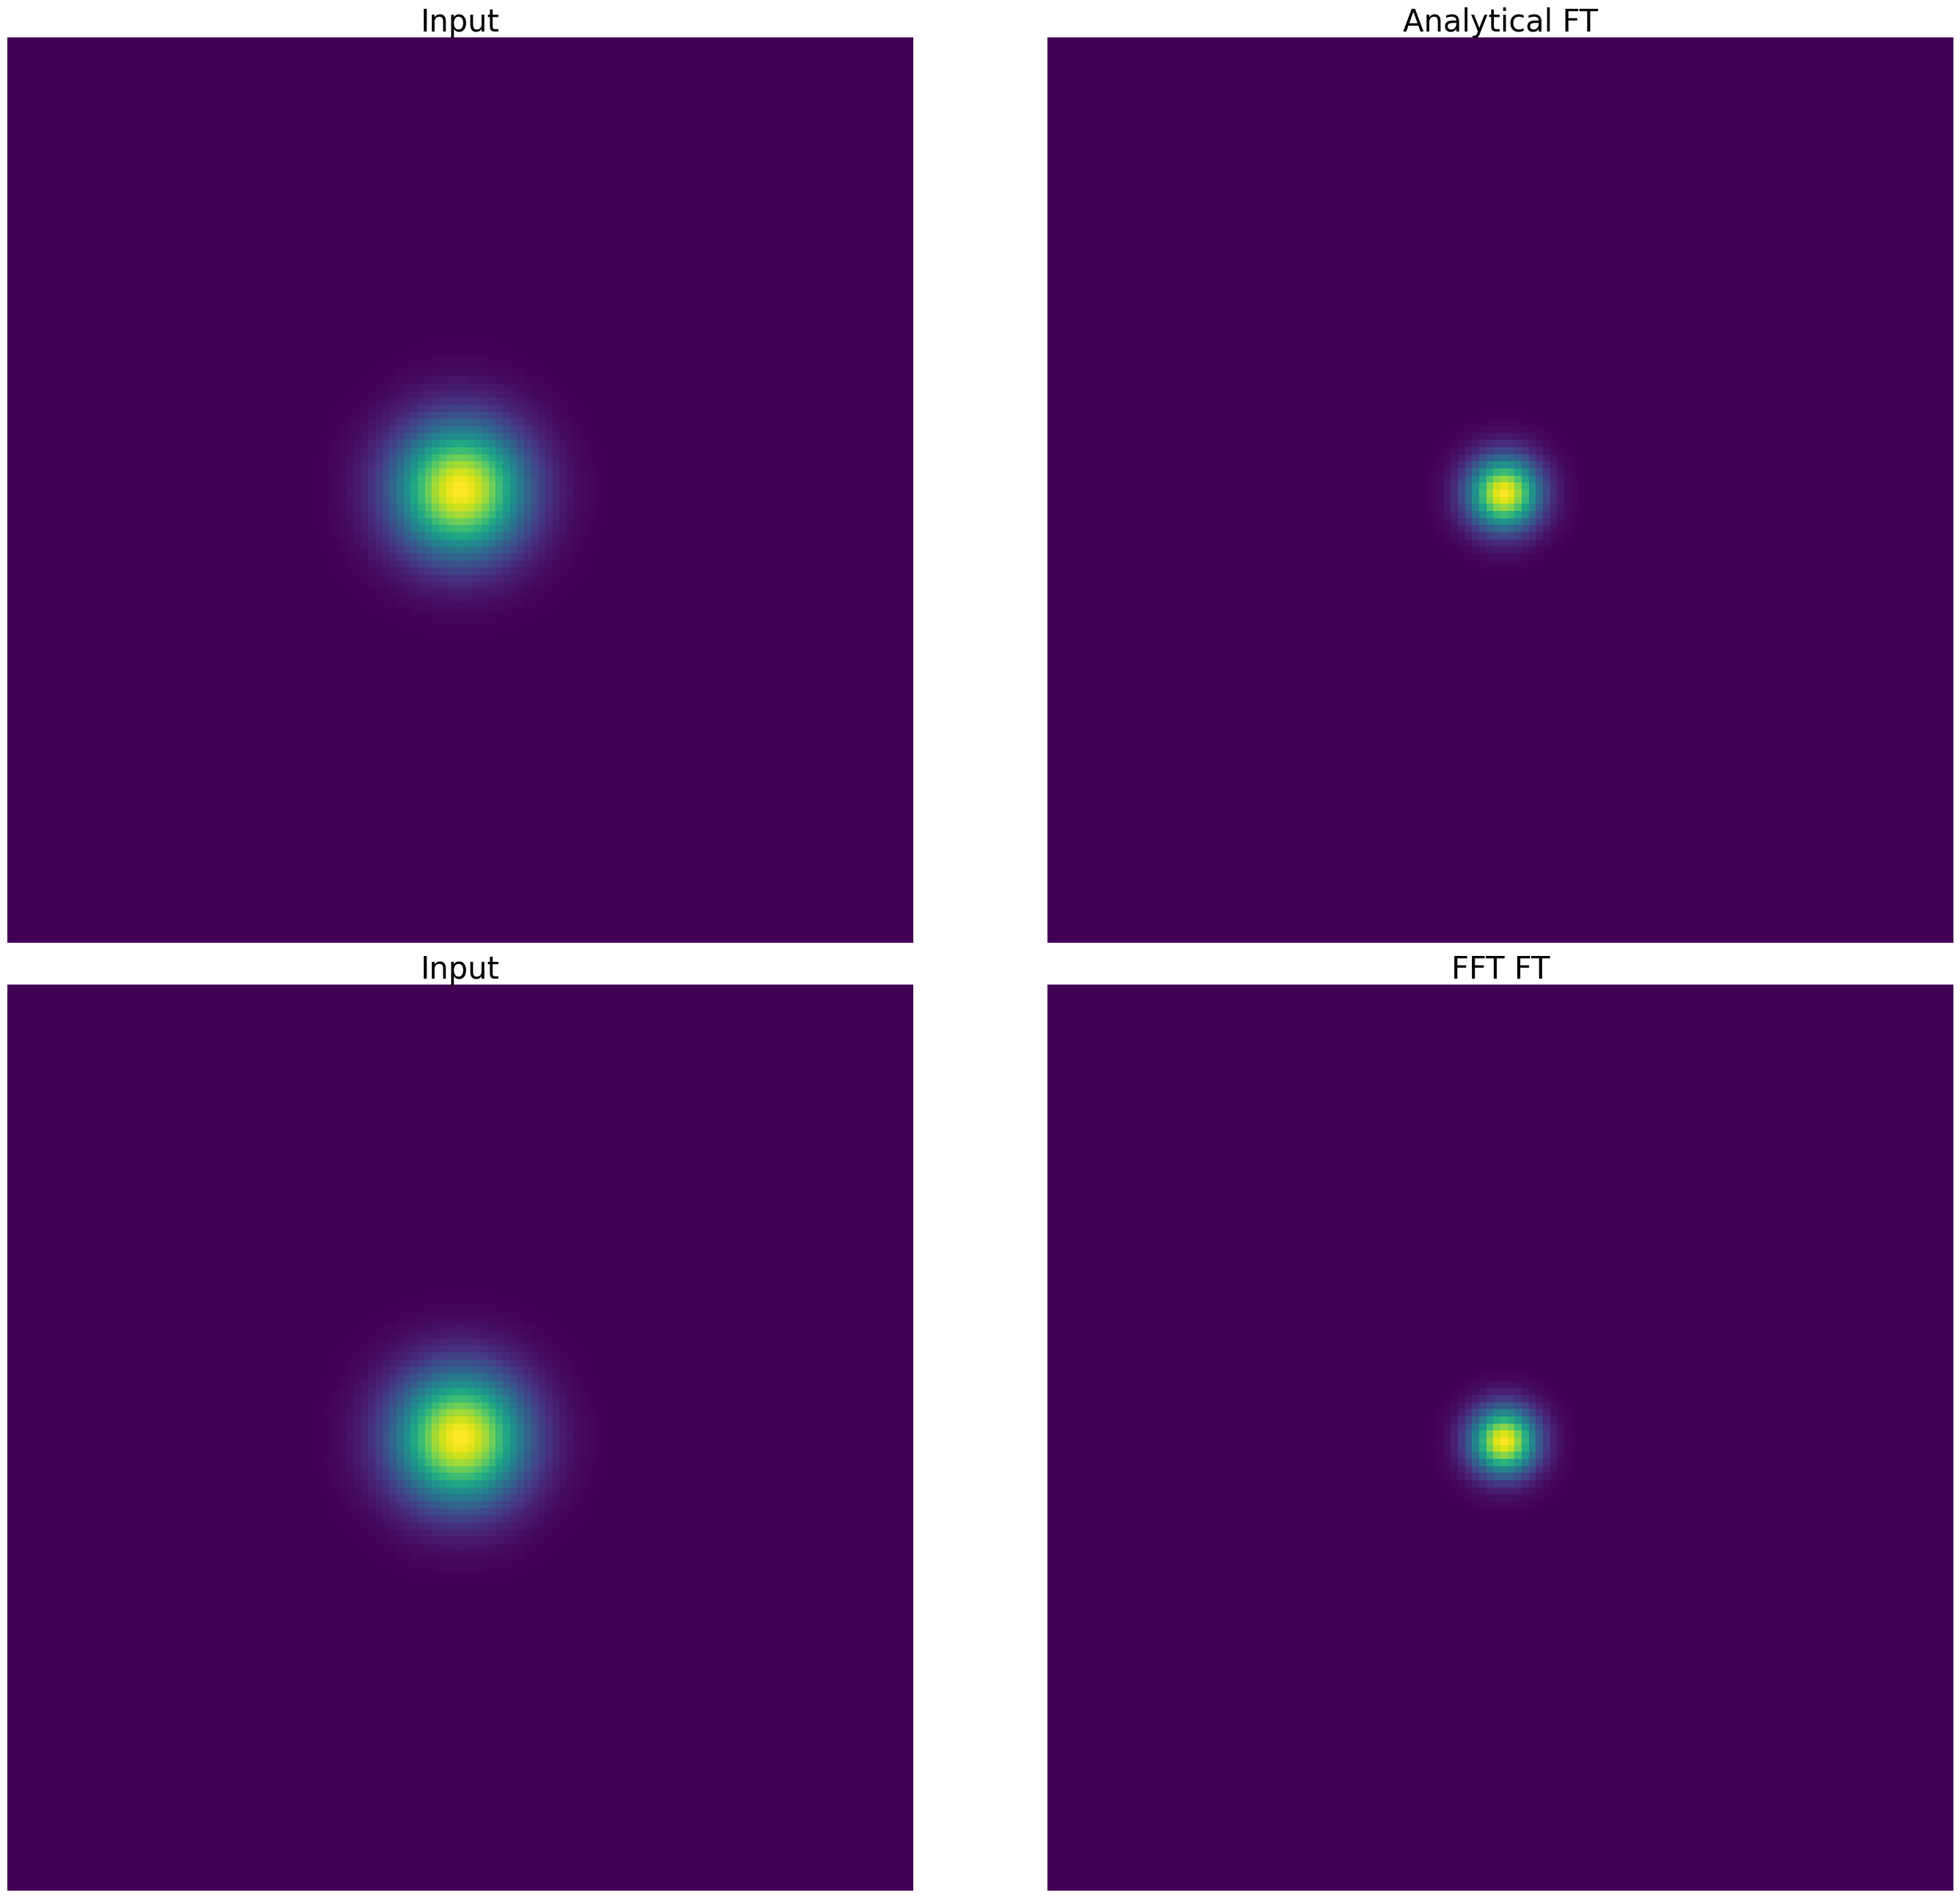

In [15]:
visualize_nonrot_FT(d=0.17)

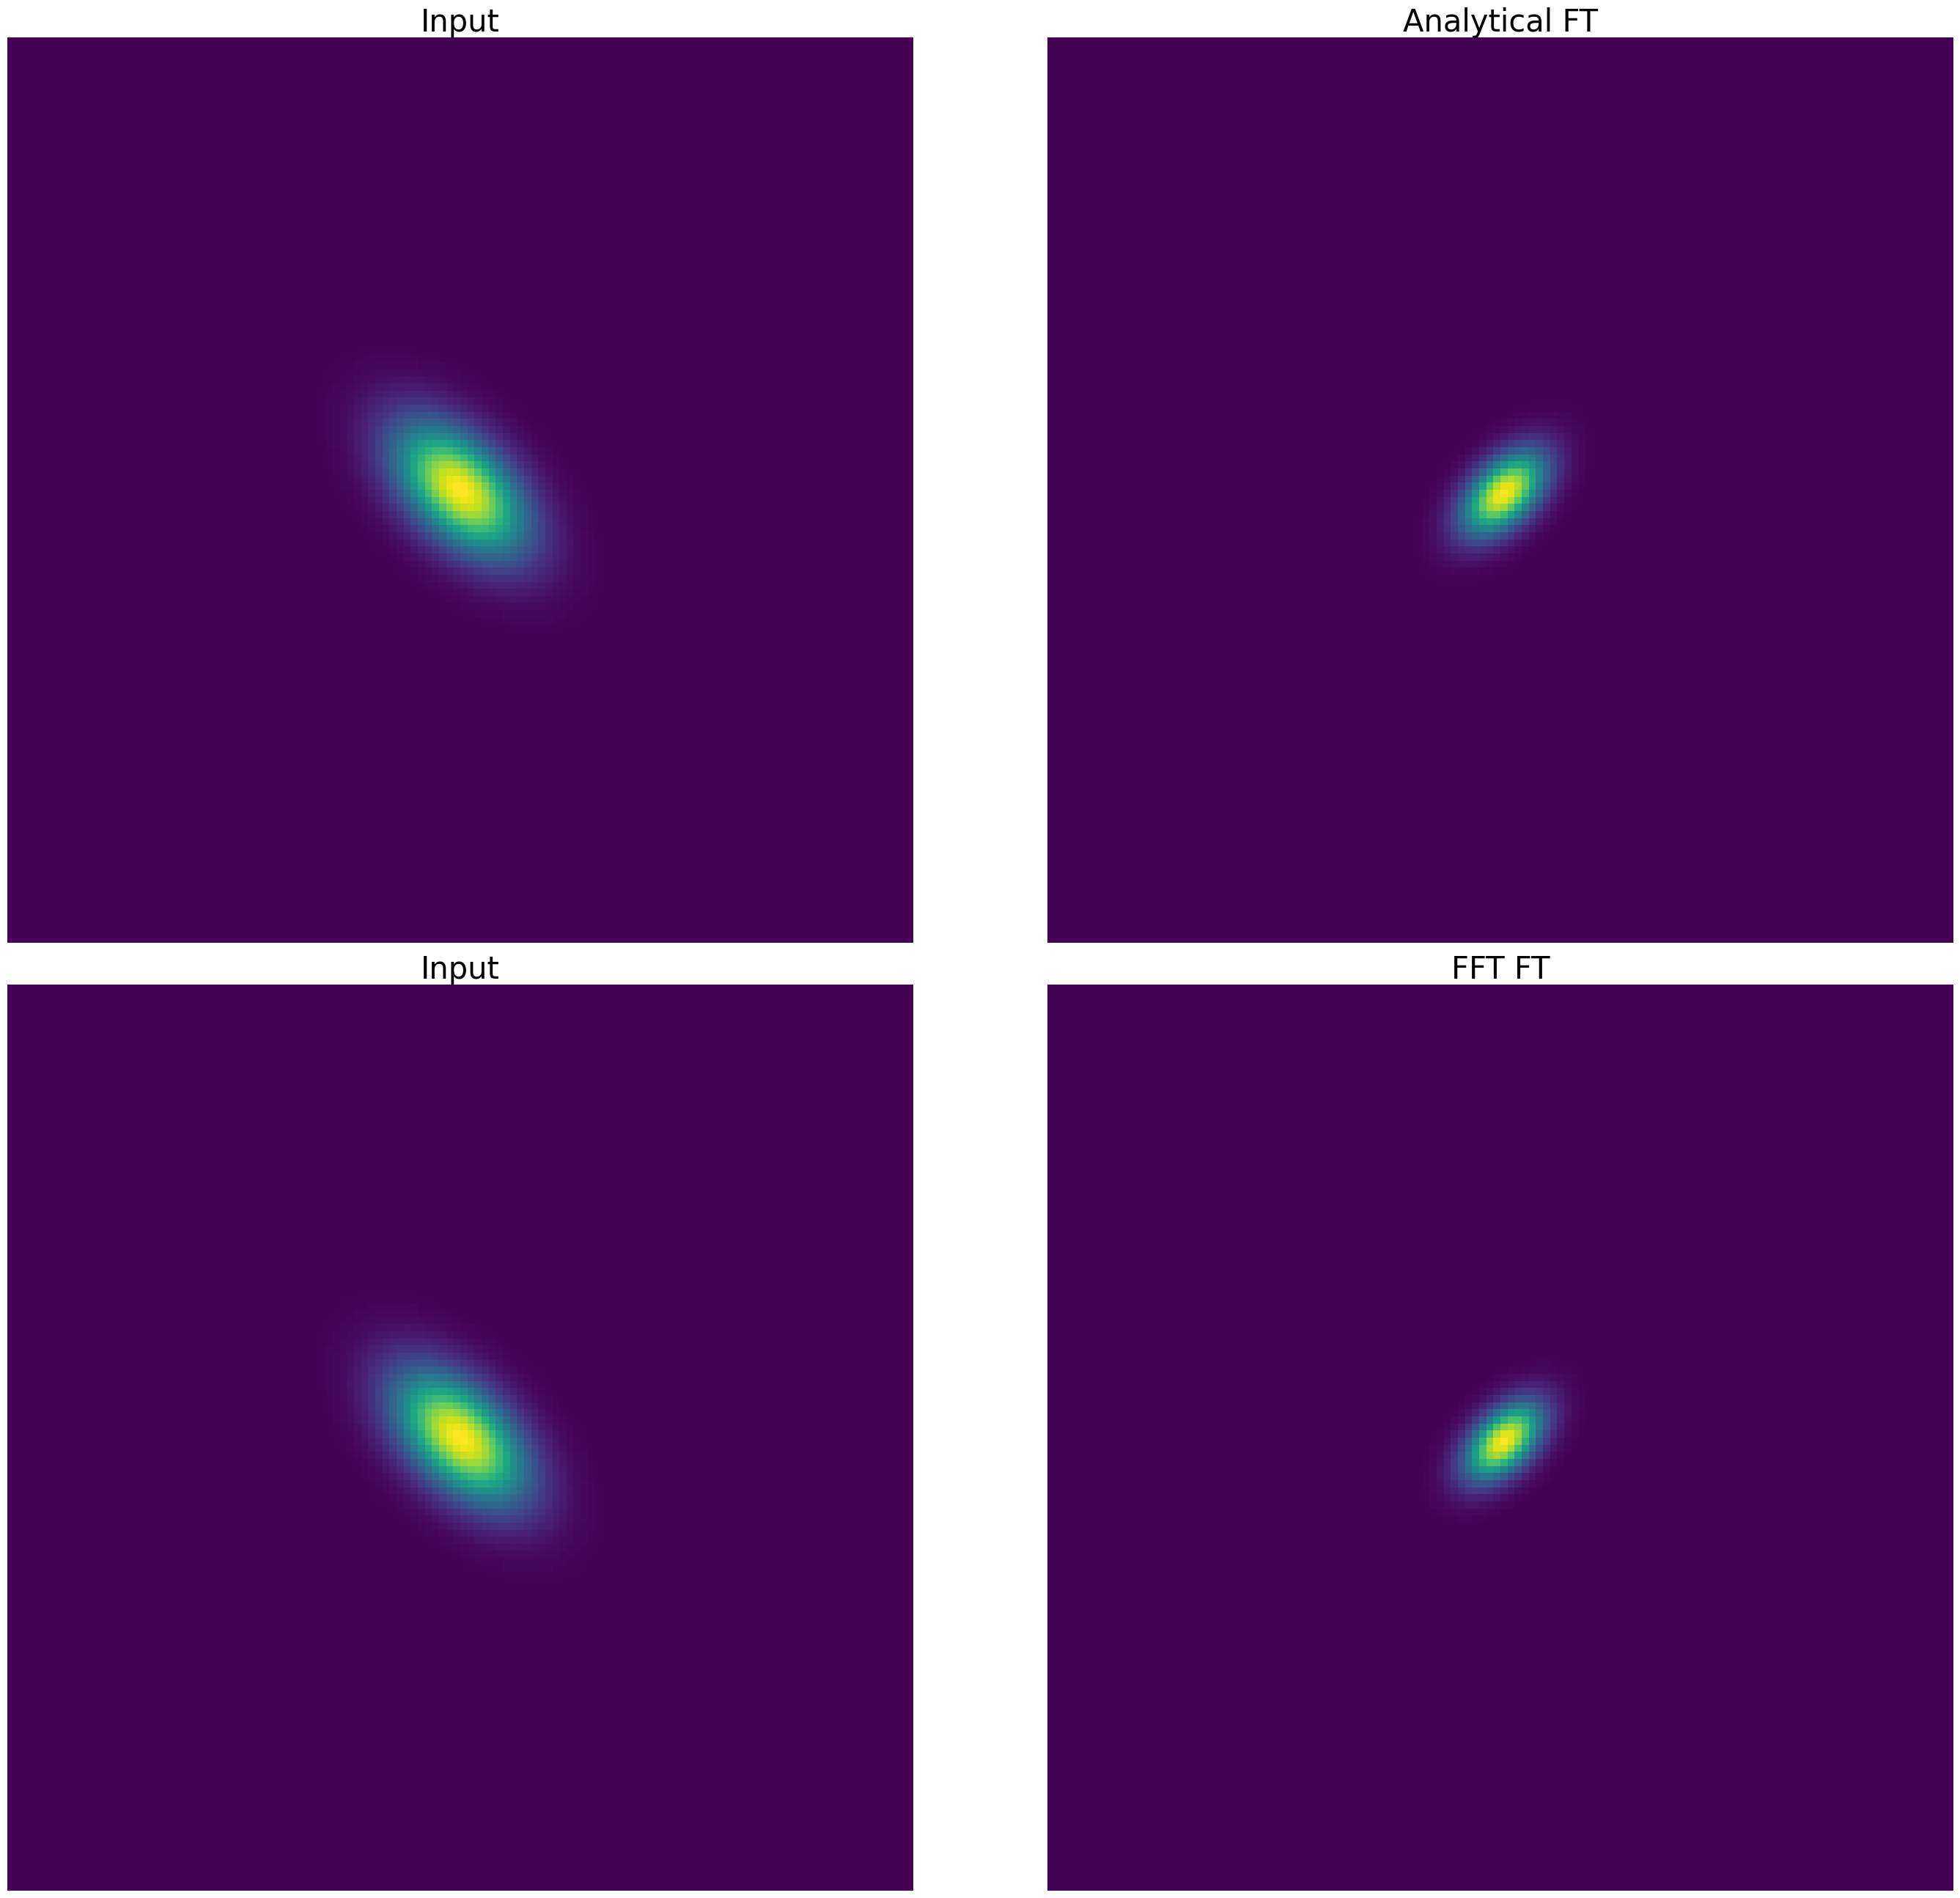

In [16]:
visualize_rot_FT(d=0.17)